In [1]:
%matplotlib inline
import os
import time
import warnings

from copy import deepcopy
from glob import glob
from PIL import Image
from PIL import ImageFile

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import functional as F

from scipy.ndimage import zoom
from torch.utils.data import DataLoader
from tqdm import tqdm


ImageFile.LOAD_TRUNCATED_IMAGES = True
warnings.filterwarnings('ignore')

In [2]:
def get_model_tranfer(model, num_classes, model_name='vgg16', use_cuda=False, freeze=False):
    model_transfer = deepcopy(model)
    
    # Freeze conv. layers to boost training and focus on 
    # the classifier, ie: fc layers
    if model_name == 'vgg16':
        for param in model_transfer.features[0:10]:
            param.requires_grad = (not freeze)
                
        # Get the number input features
        in_features = model.classifier[-1].in_features
        # Update classifier fully connected (fc) layer
        model_transfer.classifier[-1] = nn.Linear(in_features, num_classes)
    elif model_name == 'resnet50':
        for param in model_transfer.layer1:
            param.requires_grad = (not freeze)
        
        # Get the number input features
        in_features = model.fc.in_features
        # Update classifier fully connected (fc) layer
        model_transfer.fc = nn.Linear(in_features, num_classes)
    elif model_name == 'densenet161':
        for param in model_transfer.features[0:5].parameters():
            param.requires_grad = (not freeze)
        
        # Get the number input features
        in_features = model.classifier.in_features
        # Update classifier fully connected (fc) layer
        model_transfer.classifier = nn.Linear(in_features, num_classes)
    else:
        raise(Exception(f'Could not find {model_name} model.'))

    if use_cuda:
        model_transfer = model_transfer.cuda()
    
    return model_transfer

In [3]:
def get_unnormalized_image(image, std, mean):
    _image = image * std
    _image += mean
    _image = np.clip(_image, 0, 1)
    _image *= 255 # Bound to RGB values [0-255]
    _image = _image.astype(np.uint8)
    return _image

In [4]:
index_dir = os.path.join('data', 'dataset', 'index')
features_dir = os.path.join('data', 'features', 'densenet161')

if not os.path.exists(features_dir):
    os.makedirs(features_dir)

classes = list(map(lambda x: os.path.basename(x), 
               glob(os.path.join(index_dir, '*'))))

images = glob(os.path.join(index_dir, '*', '*'))
    
image_size = 224
resize_size = int(image_size * 1.35)

mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(resize_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])

In [5]:
class_labels = {}
for i, c in enumerate(classes):
    class_labels[c] = i
class_labels

{'cat': 0, 'house': 1, 'tulip': 2, 'car': 3, 'dog': 4}

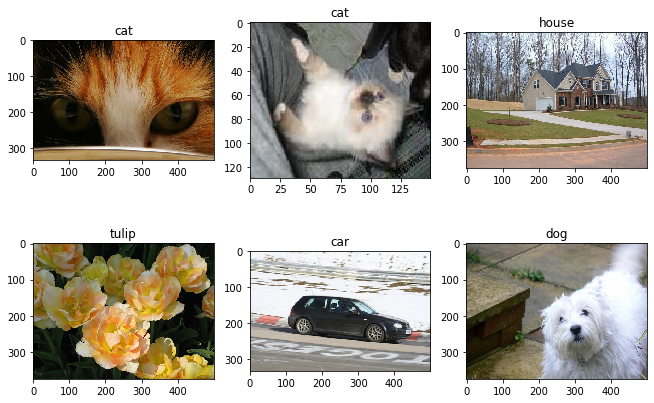

In [6]:
fig = plt.figure(figsize=(11, 11))
for i in range(0, len(images), 30):
    path = images[i]
    class_name = path.split('/')[-2]
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    ax = fig.add_subplot(3, 3, i//30 + 1)
    ax.set_title(class_name, fontdict={'fontsize': 'large'})
    ax.imshow(image)
    
plt.show()

In [7]:
num_classes = len(classes)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# Download pre-trained models and update 
# fully connected layer with the new classes
# RESNET50 = models.resnet50(pretrained=True)
# resnet_transfer = get_model_tranfer(RESNET50, num_classes, 
#                                     'resnet50', use_cuda, 
#                                     freeze=True)

DENSENET161 = models.densenet161(pretrained=True)
densenet_transfer = get_model_tranfer(DENSENET161, num_classes, 
                                      'densenet161', use_cuda, 
                                      freeze=True)

# VGG16 = models.vgg16(pretrained=True)
# vgg_transfer = get_model_tranfer(VGG16, num_classes, 
#                                  'vgg16', use_cuda,
#                                  freeze=True)

In [8]:
# print('ResNet50:', resnet_transfer.fc)
# print('-' * 65) 
# print('VGG16:', vgg_transfer.classifier)
# print('-' * 65) 
print('DenseNet161:', densenet_transfer.classifier)

DenseNet161: Linear(in_features=2208, out_features=5, bias=True)


In [9]:
model_path = os.path.join('models', 'model_densenet.pt')
densenet_transfer.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [10]:
tensor = torch.unsqueeze(transform(image), dim=0)
print(tensor.shape)
densenet_transfer.features(tensor.cuda()).shape

torch.Size([1, 3, 224, 224])


torch.Size([1, 2208, 7, 7])

In [11]:
features = {}
densenet_transfer.eval()
for image in tqdm(images):
    path = image
    class_name = path.split('/')[-2]
    label = class_labels[class_name]
    image_name = os.path.basename(path).split('.')[0]
    outfile = os.path.join(features_dir, f'{image_name}.npy')
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    tensor = transform(image).cuda()
    tensor = torch.unsqueeze(tensor, dim=0)
    features = densenet_transfer.features(tensor).cpu()
    features = features.detach().numpy().ravel()
    tensor = tensor.cpu()
    
    with open(outfile, 'wb+') as f:
        np.save(f, [features, class_name])

100%|██████████| 157/157 [00:05<00:00, 30.72it/s]


In [12]:
feats, class_name = np.load(os.path.join(features_dir, '1037384498_a60207839a.npy'), allow_pickle=True)

In [13]:
feats.shape

(108192,)